In [412]:
#importing packages 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


Importing test and training dataset

In [413]:
train = pd.read_csv("C:/Users/Saurabh Singh/Desktop/APA/House Prices/train.csv")
test = pd.read_csv("C:/Users/Saurabh Singh/Desktop/APA/House Prices/test.csv")
c_test = test.copy()
c_train = train.copy()

Joining the test and training dataset for cleaning to make the cleaning process time effiecient otherwise we would have to clean train and test data separetly which would be time consuming.

In [414]:
c_train['train'] = 1
c_test['train'] = 0
df=pd.concat([c_train, c_test],axis=0)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


Finding correlation Matrix between variables 

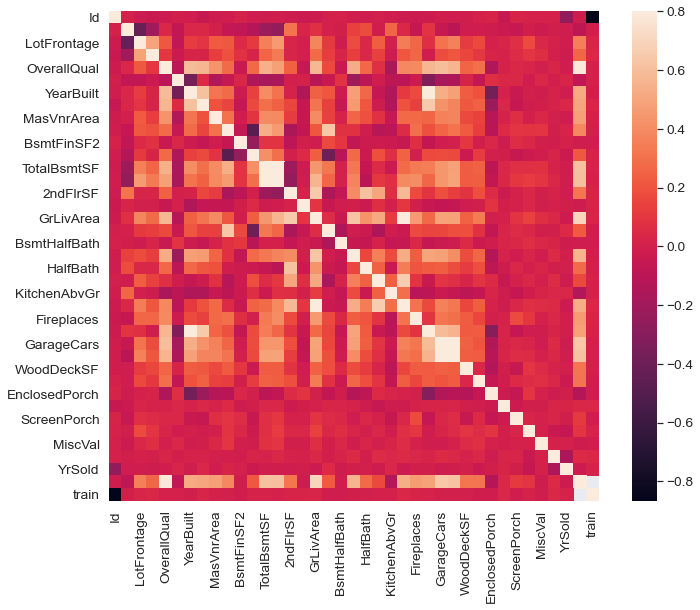

In [415]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Using Heatmap to find correlation between variables as it a good way to get a quick overview of relationship between variables. 
 On a first look we see two big squares that attract attention which are   'TotalBsmtSF' and '1stFlrSF' variables and 'grage' variables.Both cases show that these variables are highly correlated. 
 This indicates multicollinearlity.If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool.

Another huge square that attracts our attention is the 'SalePrice' correlations. We can see  'GrLivArea', TotalBsmtSF', and 'OverallQual' variables displaying correlation, but we can also see many other variables that should be taken into account. That's what we choose to do next. We take these variables into account and create a correlation matrix between the target variable 'SalePrice' and feature variables.

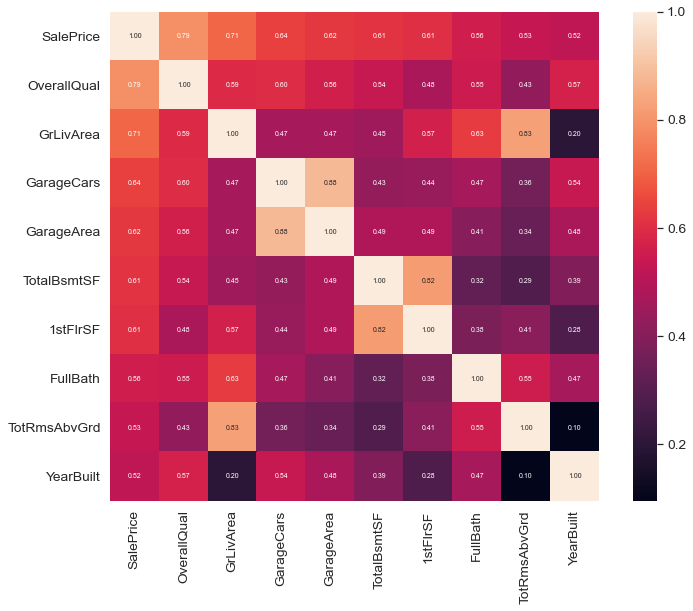

In [416]:
# saleprice correlation matrix
corr_num = 10 #number of variables for heatmap
cols_corr = corrmat.nlargest(corr_num, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(train[cols_corr].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(corr_mat_sales, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.show()


Calculating percentage of missing values

In [417]:
#Percentage of NAN Values 
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

We find Features with more than 50% of missing values and later drop the, because there is no point in keeping values with huge amount of missing values as they would not contribute enough in the final classification and we can save ourselves some time by not trying to fill these values.


In [418]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)


,column_name,percentage
72,PoolQC,99.657417
74,MiscFeature,96.402878
6,Alley,93.216855
73,Fence,80.438506


PoolQC, MiscFeature, Alley, Fence have more than 80% missing values

In [419]:
df = df.drop(['Alley','Fence','MiscFeature'],axis=1)


dividing into Categorical and numerical features.

In [420]:
object_columns_df = df.select_dtypes(include=['object'])
numerical_columns_df =df.select_dtypes(exclude=['object'])

Now we find number of null values in categorical features. 

In [421]:
#Number of null values in each feature
null_counts = object_columns_df.isnull().sum().sort_values(ascending=False)

print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
PoolQC           2909
FireplaceQu      1420
GarageCond        159
GarageQual        159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MSZoning            4
Utilities           2
Functional          2
Electrical          1
KitchenQual         1
SaleType            1
Exterior2nd         1
Exterior1st         1
BldgType            0
LandContour         0
LotShape            0
LotConfig           0
LandSlope           0
Street              0
Neighborhood        0
Condition1          0
Condition2          0
SaleCondition       0
HouseStyle          0
RoofStyle           0
RoofMatl            0
ExterQual           0
ExterCond           0
Heating             0
HeatingQC           0
CentralAir          0
PavedDrive          0
Foundation          0
dtype: int64


We will fill -  **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, FireplaceQu, GarageCond** -- with "None" since the missing value indicates that there is no garage or basement in the property


In [422]:
columns_None = ['BsmtQual','PoolQC','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_columns_df[columns_None]= object_columns_df[columns_None].fillna('None')

fill missing values for each column (using its own most frequent value) - WHY?


In [423]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])

Now we clean the numerical values

In [424]:
#Number of null values in each feature
null_counts = numerical_columns_df.isnull().sum().sort_values(ascending=False)

print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
SalePrice        1459
LotFrontage       486
GarageYrBlt       159
MasVnrArea         23
BsmtFullBath        2
BsmtHalfBath        2
GarageCars          1
TotalBsmtSF         1
BsmtUnfSF           1
BsmtFinSF2          1
GarageArea          1
BsmtFinSF1          1
LowQualFinSF        0
YearRemodAdd        0
YearBuilt           0
OverallCond         0
OverallQual         0
1stFlrSF            0
2ndFlrSF            0
LotArea             0
MSSubClass          0
train               0
FullBath            0
GrLivArea           0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
Id                  0
dtype: int64


1) We Fill GarageYrNlt and LotFrontage with Median vlaue as both of them contain null values and we have to fill them to use them for classifcation. 


In [425]:
print((numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt']).median())
print(numerical_columns_df["LotFrontage"].median())


35.0
68.0


2) Fill rest of columns with 0 as they do not have many missing values, hence we can just fill them up with 0

In [426]:
numerical_columns_df= numerical_columns_df.fillna(0)


Now we have a clean dataset

After making some plots we found that we have some colums with low variance so we decide to delete them.

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64

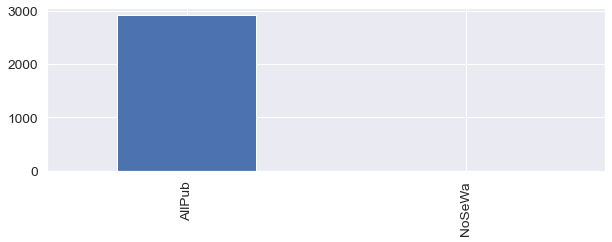

In [427]:
object_columns_df['Utilities'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Utilities'].value_counts() 

Pave    2907
Grvl      12
Name: Street, dtype: int64

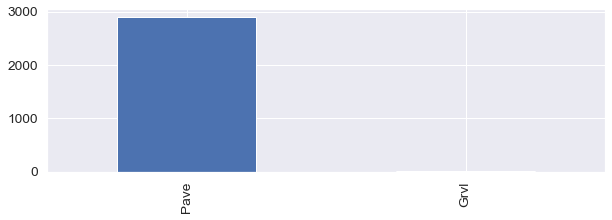

In [428]:
object_columns_df['Street'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Street'].value_counts() 

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

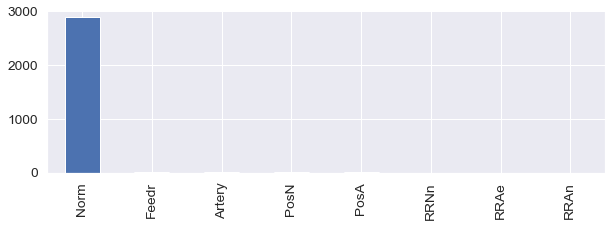

In [429]:
object_columns_df['Condition2'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Condition2'].value_counts() 

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
ClyTile       1
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

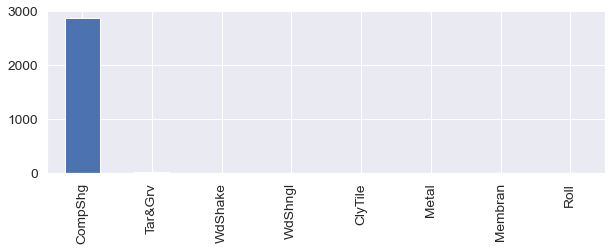

In [430]:
object_columns_df['RoofMatl'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['RoofMatl'].value_counts() 

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

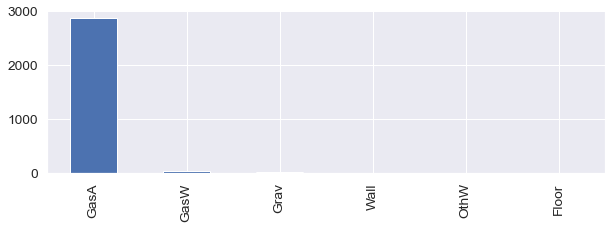

In [431]:
object_columns_df['Heating'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Heating'].value_counts() #======> Drop feature one Type

In [432]:
object_columns_df = object_columns_df.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)

Now we create new feature such as Age_house which can basically be formed by subtracting the year the house was sold by the year it was built, by doing this we reduce the number of features and make the algorithm more efficient. 

In [433]:
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

In [434]:
Negatif = numerical_columns_df[numerical_columns_df['Age_House'] < 0]
Negatif

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,0,17000,10,2007,0.0,0,-1


 Like we see here tha the minimun is -1.
It is strange to find that the house was sold in 2007 before the YearRemodAdd 2009.

So we decide to change the year of sold to 2009 

In [435]:
numerical_columns_df.loc[numerical_columns_df['YrSold'] < numerical_columns_df['YearBuilt'],'YrSold' ] = 2009
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count    2919.000000
mean       36.480644
std        30.335358
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64



    TotalBsmtBath : Sum of : BsmtFullBath and 1/2 BsmtHalfBath

    TotalBath : Sum of : FullBath and 1/2 HalfBath

    TotalSA : Sum of : 1stFlrSF and 2ndFlrSF and basement area </font>



In [436]:
numerical_columns_df['TotalBsmtBath'] = numerical_columns_df['BsmtFullBath'] + numerical_columns_df['BsmtFullBath']*0.5
numerical_columns_df['TotalBath'] = numerical_columns_df['FullBath'] + numerical_columns_df['HalfBath']*0.5 
numerical_columns_df['TotalSA']=numerical_columns_df['TotalBsmtSF'] + numerical_columns_df['1stFlrSF'] + numerical_columns_df['2ndFlrSF']


Next step is to encode the categorical feature. - Why do we encode only few varaibles manually and rest with one hot encoder? 

In [437]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
object_columns_df['ExterQual'] = object_columns_df['ExterQual'].map(bin_map)
object_columns_df['ExterCond'] = object_columns_df['ExterCond'].map(bin_map)
object_columns_df['BsmtCond'] = object_columns_df['BsmtCond'].map(bin_map)
object_columns_df['BsmtQual'] = object_columns_df['BsmtQual'].map(bin_map)
object_columns_df['HeatingQC'] = object_columns_df['HeatingQC'].map(bin_map)
object_columns_df['KitchenQual'] = object_columns_df['KitchenQual'].map(bin_map)
object_columns_df['FireplaceQu'] = object_columns_df['FireplaceQu'].map(bin_map)
object_columns_df['GarageQual'] = object_columns_df['GarageQual'].map(bin_map)
object_columns_df['GarageCond'] = object_columns_df['GarageCond'].map(bin_map)
object_columns_df['CentralAir'] = object_columns_df['CentralAir'].map(bin_map)
object_columns_df['LotShape'] = object_columns_df['LotShape'].map(bin_map)
object_columns_df['BsmtExposure'] = object_columns_df['BsmtExposure'].map(bin_map)
object_columns_df['BsmtFinType1'] = object_columns_df['BsmtFinType1'].map(bin_map)
object_columns_df['BsmtFinType2'] = object_columns_df['BsmtFinType2'].map(bin_map)
object_columns_df['PoolQC'] = object_columns_df['PoolQC'].map(bin_map)



PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
object_columns_df['PavedDrive'] = object_columns_df['PavedDrive'].map(PavedDrive)

Will we use One hot encoder to encode the rest of categorical features 

In [438]:
#Select categorical features
rest_object_columns = object_columns_df.select_dtypes(include=['object'])
#Using One hot encoder
object_columns_df = pd.get_dummies(object_columns_df, columns=rest_object_columns.columns) 

 Concat Categorical (after encoding) and numerical features 

In [439]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,3,4,2,4,2,2,6,1,4,1,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,3,2,2,4,2,4,5,1,4,1,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,2,4,2,4,2,2,6,1,4,1,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,2,2,2,2,4,2,5,1,4,1,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,2,4,2,4,2,3,6,1,4,1,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


There is no ID column because it is not a property of the home that should have an influence on the SalePrice. There is a correlation between ID and Price in the dataset, this would probably have a different reason (e.g. correlation of ID with the age of the home, or with the location, having its origin in the way the data was collected), but taking into account this correlation would most certainly have a negative influence on the quality of the prediction (because in our case ID's have been (re)assigned in a systematic way as to have ID( training ) = 1..1460 and ID(test) = 1461..2920).


In [440]:
df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train',],axis=1)

 Separate Train and Targets 

In [441]:
target= df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

MODELLING

In [442]:
x_train,x_test,y_train,y_test = train_test_split(df_train,target,test_size=0.33,random_state=0)

In [443]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor



#XGB
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression',num_leaves=4, learning_rate=0.01, n_estimators=12000,                        max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train, eval_metric='rmse')
# Score model
print(xgb.score(x_train,y_train))
print(lgbm.score(x_train, y_train))




[20:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.9957738967467392
0.9901928366240415


In [444]:
import math
import sklearn.metrics as metrics

y_lgbm_pred = lgbm.predict(x_test)
print('LGBM Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, y_lgbm_pred))))
y_xgb_pred = xgb.predict(x_test)
print('xgb Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, y_xgb_pred))))


LGBM Root Mean Square Error test = 27094.540069019327
xgb Root Mean Square Error test = 26036.438574968204


Fitting With all the dataset 

In [445]:
xgb.fit(df_train, target)
lgbm.fit(df_train, target,eval_metric='rmse')

[20:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [446]:
predict4 = lgbm.predict(df_test)
predict3 = xgb.predict(df_test)
predict_y = ( predict3*0.45 + predict4 * 0.55)
print(predict_y)

[124893.82160943 165128.82677543 187667.09780617 ... 165693.47406992
 120250.87971801 214873.13507254]


In [447]:
final_test_predictions
 = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predict_y
    })
print(final_test_predictions)

        Id      SalePrice
0     1461  124893.821609
1     1462  165128.826775
2     1463  187667.097806
3     1464  195533.738897
4     1465  188390.881942
...    ...            ...
1454  2915   85057.776986
1455  2916   82227.959069
1456  2917  165693.474070
1457  2918  120250.879718
1458  2919  214873.135073

[1459 rows x 2 columns]
